# Исследование данных на качество

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, mannwhitneyu, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

**Нужно поменять путь к файлу!!!**

In [2]:
FILENAME = '/content/analysing_environmental_issues.csv'
df = pd.read_csv(FILENAME)

## Удаление пустых строк

In [3]:
nan_cols = ['stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift']
df.dropna(subset=nan_cols, how='all', inplace=True)

## Привидение к нужному типу

In [4]:
df['work_shift'] = df['work_shift'].astype('int')

## Создание колонок month и day

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['month'] = df['DateTime'].dt.strftime('%Y-%m')
df['day'] = df['DateTime'].dt.strftime('%Y-%m-%d')

## Заполнение пропусков

In [6]:
nan_cols = list(df.columns[df.isna().sum() > 0])
nan_cols.remove('stage_4_output_danger_gas')

In [7]:
for col in nan_cols:
  df[col] = df[col].interpolate(method='nearest')

## Расчёты

### Категория опасности газа

In [8]:
df['stage_4_output_danger_gas_cat'] = df['stage_4_output_danger_gas'].apply(lambda x: 1 if x < 0.05 else 2 if x <= 0.16 else 3)

### Сводная таблица траты ресурсов по дням

In [9]:
input_params = [col for col in df.columns if 'input' in col]
output_params = [col for col in df.columns if 'output' in col]
new_df = df.groupby('day')[input_params].agg('sum')

In [10]:
def sum_water(row):
  return row['stage_2_input_water_sum'] + row['stage_3_input_soft_water'] + row['stage_4_input_water']

In [11]:
def sum_steam(row):
  return row['stage_3_input_steam'] + row['stage_4_input_overheated_steam'] + row['stage_4_input_steam']

In [12]:
new_df['input_water_sum'] = new_df.apply(sum_water, axis=1)
new_df['input_steam_sum'] = new_df.apply(sum_steam, axis=1)

In [13]:
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1 * iqr
    upper_bound = q3 + 1 * iqr

    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [14]:
for col in new_df:
  print(find_outliers(new_df, col)[col])

day
2021-02-06    3103.94
2021-02-07    3104.14
2021-02-13    3108.51
2021-02-14    3202.86
2021-04-14    4050.39
2021-04-15    4469.87
2021-04-18    3777.05
2021-04-19    3451.90
Name: stage_2_input_water_sum, dtype: float64
Series([], Name: stage_3_input_pressure, dtype: float64)
day
2021-02-06    10790.96
2021-08-06    11351.97
2021-08-07    13375.47
2021-11-25    13073.06
2021-11-26    12366.27
2021-11-27    12471.01
2021-11-28    12528.38
2021-11-29    12227.16
2021-11-30    11367.87
2021-12-07    12670.98
2021-12-08    11958.68
2022-06-09    11228.88
2022-06-12    13106.47
2022-06-13    12076.93
2022-07-17    10830.04
2022-07-21    13142.80
2022-07-23    11049.59
Name: stage_3_input_soft_water, dtype: float64
day
2021-02-06    37991.77
2021-02-07    37326.20
2021-03-18    33633.42
2022-02-23    32047.00
2022-02-24    33638.12
2022-02-25    33259.79
2022-02-26    31933.65
2022-02-28    31678.81
Name: stage_3_input_steam, dtype: float64
Series([], Name: stage_4_input_overheated_ste

6-7 февраля 2021 заметно высокое потребление воды и пара.

### Сводная таблица категории опасности по месяцам

In [15]:
df.groupby('month')['stage_4_output_danger_gas_cat'].apply(lambda x: x.mode()[0])

,stage_4_output_danger_gas_cat
month,
2021-01,3
2021-02,3
2021-03,3
2021-04,3
2021-08,3
2021-09,3
2021-11,3
2021-12,3
2022-01,3


В основном категория опасности - 3 (высокая), в сентябре-ноябре 2022 производство было менее опасным (2 категория).

### Средние значения параметров по категориям опасности

In [16]:
df.groupby('stage_4_output_danger_gas_cat').mean(numeric_only=True)

,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,stage_2_output_top_vacuum,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
stage_4_output_danger_gas_cat,,,,,,,,,,,,,,,,,,,,,
1,65.830000,80.640000,383.996000,78.536000,101.944000,56.360000,450.904000,266.380000,93.890000,58.212000,...,109.586000,41.268000,153.314000,18.092000,4.612000,232.050000,0.036000,21.800000,43.484000,1.800000
2,69.043094,87.720791,396.106863,79.030446,98.170892,56.532460,455.714518,262.289525,94.356403,59.211165,...,109.453698,42.289899,153.342173,20.089957,5.269151,299.922475,0.124201,22.266331,44.072734,1.494964
3,69.541215,86.509124,405.641234,79.249328,98.533647,56.802028,449.077288,261.437698,94.673017,59.017537,...,110.105356,42.882119,153.468797,20.186432,5.429065,317.062862,0.189701,22.472853,46.797277,1.480226


Итак, на высокую категорию опасности влияют:

1 стадия:

*   большая доля конверсии сырья в мономер

2 стадия:

*   много воды, подаваемой в агрегат
*   высокое давление низа в агрегате
*   низкое давление верха в агрегате на выходе

3 стадия:

*   мало смягчённой воды
*   экстремально много подаваемого пара

4 стадия:

*   большое кол-во подаваемого полимера
*   большая подача пара
*   слишком много подаваемой воды
*   бОльшее кол-во готового продукта

### Корреляционный анализ

In [17]:
numeric_columns = df.select_dtypes(include=['number']).columns

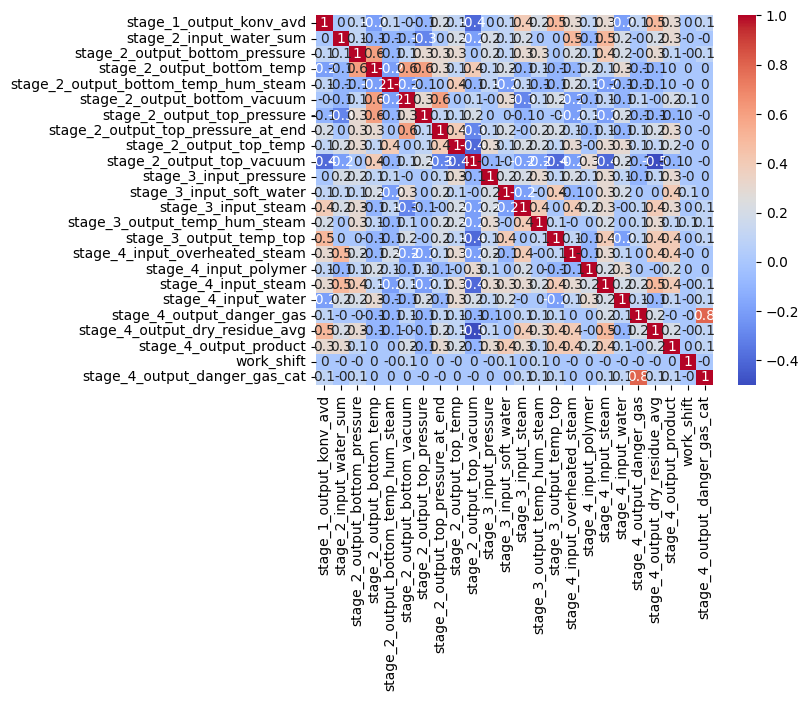

In [18]:
corr_matrix = df[numeric_columns].corr().round(1)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

На большой процент сухого остатка влияет:

*   большой процент конверсии сырья в мономер
*   мало вакуума верха на 2 стадии
*   много подаваемого пара на 3 стадии
*   высокая температура верха в агергате на 3 стадии
*   много перегретого пара на 4 стадии
*   много подаваемого пара на 4 стадии

На большую массу готового продукта влияют:

*   большая подача смягчённой воды
*   высокая температура верха в агергате на 3 стадии
*   много перегретого пара на 4 стадии
*   много подаваемого пара на 4 стадии

## Проверка гипотез

### 1

Используем только те данные, где нет пропусков в колонке `stage_4_output_danger_gas`.

In [19]:
df1 = df.dropna()

In [20]:
g1 = df1[df1['work_shift'] == 1]['stage_4_output_danger_gas']
g2 = df1[df1['work_shift'] == 2]['stage_4_output_danger_gas']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем метод Манна-Уитни.

In [23]:
mannwhitneyu(g1, g2, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(110984.0), pvalue=np.float64(0.6313715279936567))

p-уровень равен 0.6, значит этих данных не достаточно, чтобы понять, есть ли различия в доле опасного газа в зависимости от смены.

### 2

In [40]:
g1 = df[df['work_shift'] == 1]['stage_3_output_temp_top']
g2 = df[df['work_shift'] == 2]['stage_3_output_temp_top']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем метод Манна-Уитни.

In [41]:
mannwhitneyu(g1, g2, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(2236663.5), pvalue=np.float64(0.8419190698315876))

p-уровень равен 0.8, значит этих данных не достаточно, чтобы понять, какая из смен лучше управляет температурой верха на 3 этапе.

### 3

In [24]:
g1 = df['stage_1_output_konv_avd']
g2 = df['stage_2_input_water_sum']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [25]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.011639408376967905), pvalue=np.float64(0.44862727055217644))

p-уровень равен 0.4, значит этих данных не достаточно, чтобы понять, влияет ли конверсия мономера на 1 этапе на количество подаваемой суммарной воды.

### 4

In [26]:
g1 = df1['stage_4_output_product']
g2 = df1['stage_4_output_danger_gas']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [27]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(-0.05170761277372991), pvalue=np.float64(0.1142906451173194))

p-уровень равен 0.1, значит этих данных не достаточно, чтобы понять, связано ли количество выходного продукта с долей опасного газа.

### 5 - Большое кол-во подаваемого пара на 3 стадии влечёт бОльший процент сухого остатка

In [28]:
g1 = df['stage_4_output_dry_residue_avg']
g2 = df['stage_3_input_steam']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [29]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.4719149819163528), pvalue=np.float64(3.690288841821099e-234))

Значение корреляции - 0.47, p-уровень меньше 0.05, значит зависимость есть, и этому значению можно доверять.

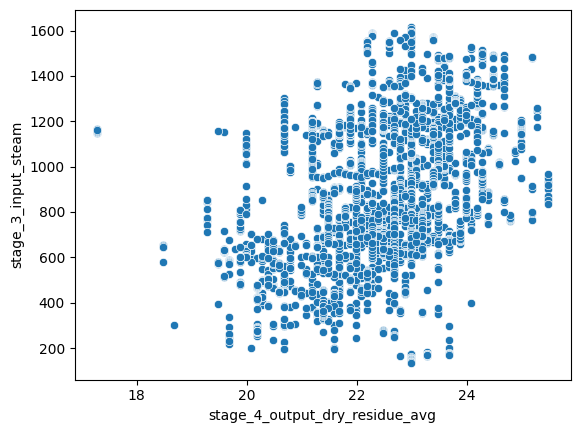

In [34]:
sns.scatterplot(data=df[['stage_4_output_dry_residue_avg', 'stage_3_input_steam']], x='stage_4_output_dry_residue_avg', y='stage_3_input_steam')
plt.show()

### 6 - Большой процент сухого остатка и большая масса готового продукта возможны ТОЛЬКО при достаточно высокой температуре верха в агрегате на 3 стадии


In [30]:
g1 = df['stage_4_output_dry_residue_avg']
g2 = df['stage_3_output_temp_top']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [31]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.1957172464322126), pvalue=np.float64(7.08111885397671e-38))

In [32]:
g1 = df['stage_4_output_product']
g2 = df['stage_3_output_temp_top']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [33]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.23493264386419765), pvalue=np.float64(2.933257197221507e-54))

В первом случае значение корреляции - 0.2, во втором - 0.23, p-уровень в обоих случаях меньше 0.05, значит небольшая зависимость есть, и этому значению можно доверять.

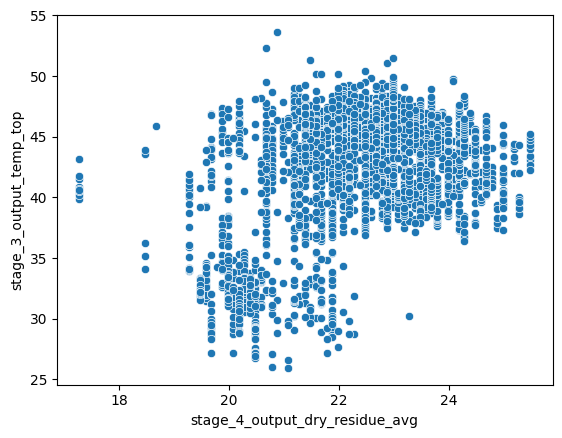

In [35]:
sns.scatterplot(data=df[['stage_4_output_dry_residue_avg', 'stage_3_output_temp_top']], x='stage_4_output_dry_residue_avg', y='stage_3_output_temp_top')
plt.show()

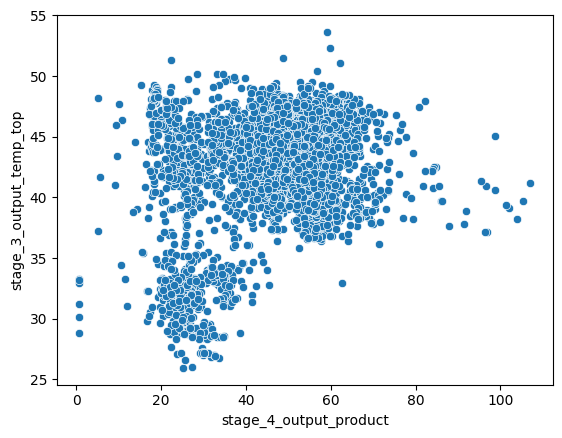

In [36]:
sns.scatterplot(data=df[['stage_4_output_product', 'stage_3_output_temp_top']], x='stage_4_output_product', y='stage_3_output_temp_top')
plt.show()

### 7 - Большое кол-во вакуума на 2 стадии НЕ даёт большой процент сухого остатка

In [37]:
g1 = df['stage_4_output_dry_residue_avg']
g2 = df['stage_2_output_top_vacuum']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [38]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(-0.39393617087685645), pvalue=np.float64(1.9927251612070704e-157))

Значение корреляции - -0.4, p-уровень меньше 0.05, значит зависимость есть, и этому значению можно доверять.

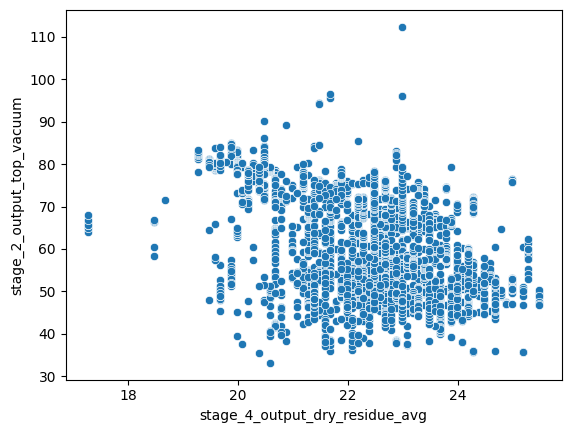

In [39]:
sns.scatterplot(data=df[['stage_4_output_dry_residue_avg', 'stage_2_output_top_vacuum']], x='stage_4_output_dry_residue_avg', y='stage_2_output_top_vacuum')
plt.show()

## Регрессионное моделирование

In [43]:
factors = df1[['stage_1_output_konv_avd', 'stage_2_output_bottom_temp',
              'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
              'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
              'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
              'stage_3_input_pressure', 'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
              'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_input_water',
              'stage_4_output_dry_residue_avg']]

In [44]:
x_train, x_test, y_train, y_test = train_test_split(factors, df1['stage_4_output_danger_gas'], test_size=0.15, random_state=42)

In [45]:
lr = LinearRegression()
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)

In [46]:
prediction

array([0.12500692, 0.15087394, 0.16754564, 0.14041651, 0.12344805,
       0.13953163, 0.11769374, 0.13958336, 0.14236654, 0.13994809,
       0.1518616 , 0.15249969, 0.16085852, 0.12638695, 0.13209589,
       0.13241279, 0.16955661, 0.13267158, 0.14545523, 0.15812794,
       0.12954975, 0.15268443, 0.13946136, 0.13662665, 0.13554571,
       0.15440333, 0.12121087, 0.13441256, 0.16478399, 0.13626421,
       0.1444667 , 0.14731971, 0.14517991, 0.12486847, 0.15735541,
       0.13498735, 0.12183664, 0.14314756, 0.12509746, 0.13710571,
       0.15131761, 0.14570053, 0.15322591, 0.15419866, 0.1477338 ,
       0.13515749, 0.12315613, 0.14492671, 0.15208775, 0.136892  ,
       0.12982061, 0.15183864, 0.12951914, 0.12443032, 0.14827136,
       0.13986142, 0.15230984, 0.15901864, 0.12832729, 0.16746243,
       0.15020824, 0.1204683 , 0.13847958, 0.13221653, 0.12116871,
       0.14810444, 0.14267739, 0.11961209, 0.12611154, 0.14303444,
       0.15141846, 0.15016656, 0.1322741 , 0.15653391, 0.13822

In [47]:
r2 = r2_score(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

In [48]:
print(r2, mape * 100)

0.08960296803196499 25.052299397490334


Значения метрик достаточно маленькие, значит предсказание модели не очень качественное. Среди данных параметров не было обнаружено тех факторов, которые сильно влияют на долю опасного газа, поэтому с помощью модели нельзя с высокой точностью предсказать эти значения.